# **Préliminaires**


# **1. Modélisation**

Cette première partie permet de récupérer et de traiter les données que nous utiliserons dans le projet.


In [ ]:
import urllib
import bs4
import pandas
import re
import numpy

### **Données sur le trafic aérien en France**


Les données sur le trafic aérien en France sont issues du site https://www.ou-et-quand.net/vols/. Afin de les récupérer, nous allons de voir faire du webscraping.

Nous commençons par récupérer l'adresse url de chaque page qui nous intéresse, c'est-à-dire chaque page concernant un aéroport français.

In [ ]:
# (A modifier : voir si on peut récupérer les noms de villes avec du webscraping)

url_radical = "https://www.ou-et-quand.net/vols/"
ordre_villes = ['Strasbourg', 'Bordeaux', 'Clermont-Ferrand', 'Rennes', 'Brest', 'Ajaccio', 'Bastia', 'Calvi', 'Figari', 'Montpellier', 'Limoges', 'Metz', 'Toulouse', 'Lille', 'Caen', 'Nantes', 'Poitiers', 'Marseille', 'Nice', 'Lyon', 'Paris']
url_terminaison = ["alsace/strasbourg/", "aquitaine/bordeaux/", "auvergne/clermont-ferrand/", "bretagne/rennes/", "bretagne/brest/", "corse/ajaccio/", "corse/bastia/", "corse/calvi/", "corse/figari/", "languedoc-roussillon/montpellier/", "limousin/limoges/", "lorraine/metz/", "midi-pyrenees/toulouse/", "nord-pas-de-calais/lille/", "normandie/caen/", "pays-de-la-loire/nantes/", "poitou-charentes/poitiers/", "provence-alpes-c-te-d-azur/marseille/", "provence-alpes-c-te-d-azur/nice/", "rh-ne-alpes/lyon/", "ile-de-france/paris/"]

Pour chaque aéroport, nous devons récupérer plusieurs données : le prix moyen du billet aller-retour en fonction des aéroports de départ, le prix moyen du billet aller-retour en fonction du mois de départ et de l'aéroport de départ ainsi que le prix moyen du billet aller-retour en fonction du délai entre la réservation et le départ et de l'aéroport de départ.

##### **Construction des expressions régulières**

On commence par construire les expressions régulières qui vont nous permettre de sélectionner les parties de la page html qui nous intéressent.

Pour récupérer les données, il faudra utiliser plusieurs expressions régulières à chaque fois.






Les expressions commençant par "expression_villes" permettent de récupérer les noms des villes de départ.

In [ ]:
expression_villes = re.compile("categories:.+],")
expression_villes_bis = re.compile(":.+],")
expression_villes_ter = re.compile("[\w]+")

Les expressions commençant par "expression_prix" permettent de récupérer les prix moyens en fonction de l'aéroport de départ.

In [ ]:
expression_prix = re.compile("""'aéroport de départ',
            data: .+,""")
expression_prix_bis = re.compile(":.+],")
expression_prix_ter = re.compile("[\d]+")

Les expressions commençant par "expression_mois" permettent de récupérer la liste des mois pour lesquels on a des données de prix.

In [ ]:
expression_mois = re.compile("""xAxis: {
            categories: .+,
            title: {
                text: null""")
expression_mois_select = re.compile("'jan.'|'fév.'|'mar.'|'avr.'|'mai'|'juin'|'juil'|'août'|'sep.'|'oct.'|'nov.'|'déc.'")
expression_mois_bis = re.compile("[\w]+")

Les expressions commençant par "expression_prix_mois" permettent de récupérer les prix moyens en fonction du mois de départ et de l'aéroport de départ.

In [ ]:
expression_prix_mois = re.compile("""en euros selon le mois de départ',
            data: .+,""")
expression_prix_mois_bis = re.compile(":.+],")
expression_prix_mois_ter = re.compile("[\d]+")

Les expressions commençant par "expression_avance" permettent de récupérer les délais entre la réservation et le départ pour lesquels on a des données de prix.

In [ ]:
expression_avance = re.compile("""xAxis: {
            categories: .+,
            title: {
                text: null""")
expression_avance_select = re.compile("'0 à 1 mois'|'1 à 2 mois'|'2 à 3 mois'|'3 à 4 mois'|'4 à 5 mois'|'5 à 6 mois'|'6 à 7 mois'|'7 à 8 mois'|'8 à 9 mois'|'9 à 10 mois'|'10 à 11 mois'|'11 à 12 mois'")
expression_avance_bis = re.compile("[\w]+")

Les expressions commençant par "expression_prix_avance" permettent de récupérer les prix moyens en fonction du délai entre le mois de départ et la réservation.

In [ ]:
expression_prix_avance = re.compile("""selon le nombre de mois entre la réservation et le vol',
            data: .+,""")
expression_prix_avance_bis = re.compile(":.+],")
expression_prix_avance_ter = re.compile("[\d]+")

##### **Récupération des données par webscraping**

Maintenant qu'on a nos expressions régulières, on peut rechercher l'ensemble des données qui nous intéressent sur les pages du site.

In [ ]:
prix_moyen_destination = []
villesbis = []
villes = []
prix = []
liste_prix = []
prix_mois = []
liste_prix_mois = []
prix_avance = []
liste_prix_avance = []
avance_mois = []
mois = []
liste_mois = []


for i in range(len(ordre_villes)):
    url_totale = url_radical+url_terminaison[i]
    
    from urllib.request import Request, urlopen
    req = Request(url_totale, headers={'User-Agent': 'Mozilla/5.0'})
    web_byte = urlopen(req).read()
    page = bs4.BeautifulSoup(web_byte, 'lxml')
    
    prix_moyen_destination.append(page.findAll("script")[23])
    s = prix_moyen_destination[i].text.strip()
    
    # seconde étape : recherche
    # Récupération des villes de départ
    city = expression_villes.findall(s)[0]
    city_bis = expression_villes_bis.findall(city)
    liste_villes = expression_villes_ter.findall(city_bis[0])
    villesbis.append(liste_villes)
    
    
    """Récupération des prix moyens en fonction de la ville de départ"""
    price_moyen_bis = expression_prix.findall(s)
    price_moyen = expression_prix_bis.findall(price_moyen_bis[0])
    prix_moyen = expression_prix_ter.findall(price_moyen[0])
    
    liste_prixbis = []

    for elem in prix_moyen:
        elem_bis = int(elem)
        liste_prixbis.append(elem_bis)
        
    liste_prix.append(liste_prixbis)
    
    
    """Récupération des prix moyens en fonction du mois de départ"""
    price_mois_bis = expression_prix_mois.findall(s)
    month = expression_mois.findall(s)
    for elem in month:
        if expression_mois_select.findall(elem) != []:
            month_select = expression_mois_select.findall(elem)
            
            for elem_bis in month_select:
                month_bis = expression_mois_bis.findall(elem_bis)
                mois.append(month_bis[0])
        
        
    for j in range(len(price_mois_bis)):
        price_mois = expression_prix_mois_bis.findall(price_mois_bis[j])
        prix_mois = expression_prix_mois_ter.findall(price_mois[0])
        liste_prixbis_mois = []

        for elem in prix_mois:
            elem_bis = int(elem)
            liste_prixbis_mois.append(elem_bis)

        liste_prix_mois.append(liste_prixbis_mois) 
    

    
    """Récupération des prix moyens en fonction du mois de réservation"""
    price_avance_bis = expression_prix_avance.findall(s)
    avance = expression_avance.findall(s)
    for elem in avance:
        if expression_avance_select.findall(elem) != []:
            avance_select = expression_avance_select.findall(elem)
            
            for elem_bis in avance_select:
                avance_bis = expression_avance_bis.findall(elem_bis)
                avance_mois.append(avance_bis[0] + ' ' + avance_bis[1] + ' ' +  avance_bis[2] + ' ' +  avance_bis[3])
        
        
    for j in range(len(price_avance_bis)):
        price_avance = expression_prix_avance_bis.findall(price_avance_bis[j])
        prix_avance = expression_prix_avance_ter.findall(price_avance[0])
        liste_prixbis_avance = []

        for elem in prix_avance:
            elem_bis = int(elem)
            liste_prixbis_avance.append(elem_bis)

        liste_prix_avance.append(liste_prixbis_avance)

##### **Création des bases de données finales**

La première base de données contiendra les prix moyens du billet aller-retour en fonction uniquement de l'aéroport de départ.

In [ ]:
col_1_1 = []
col_1_2 = []
col_1_3 = []
col_1_4 = []

for l in range(len(villesbis)):
    col_1_1 = col_1_1 + villesbis[l]
    col_1_2 = col_1_2 + [ordre_villes[l]]*len(villesbis[l])
    col_1_3 = col_1_3 + liste_prix[l]

In [ ]:
table_prix_trajet = pandas.DataFrame({'Départ' : col_1_1 , 'Arrivée': col_1_2 , 'Prix': col_1_3})
table_prix_trajet

,Départ,Arrivée,Prix
0,Paris,Strasbourg,248
1,Nantes,Strasbourg,177
2,Marseille,Strasbourg,215
3,Bordeaux,Strasbourg,227
4,Bruxelles,Strasbourg,205
...,...,...,...
162,Bruxelles,Paris,254
163,Genève,Paris,184
164,Lyon,Paris,170
165,Toulouse,Paris,122


La deuxième base de données contiendra les prix moyens du billet aller-retour en fonction du mois de départ et de l'aéroport de départ.

In [ ]:
col_2_1 = []
col_2_2 = []
col_2_3 = []
col_2_4 = mois
num_list = 0

for k in range(len(ordre_villes)):
    for l in range(len(villesbis[k])):
        col_2_1 = col_2_1 + [villesbis[k][l]]*len(liste_prix_mois[num_list])
        col_2_2 = col_2_2 + [ordre_villes[k]]*len(liste_prix_mois[num_list])
        col_2_3 = col_2_3 + liste_prix_mois[num_list]
        num_list = num_list + 1

In [ ]:
table_prix_mois = pandas.DataFrame({'Départ' : col_2_1 , 'Arrivée': col_2_2 , 'Prix': col_2_3, 'Mois': col_2_4})
table_prix_mois[:100]

,Départ,Arrivée,Prix,Mois
0,Paris,Strasbourg,310,jan
1,Paris,Strasbourg,189,fév
2,Paris,Strasbourg,225,mar
3,Paris,Strasbourg,234,avr
4,Paris,Strasbourg,256,mai
...,...,...,...,...
95,Nice,Strasbourg,130,fév
96,Nice,Strasbourg,186,mar
97,Nice,Strasbourg,154,avr
98,Nice,Strasbourg,164,mai


La troisième base de données contiendra les prix moyens du billet aller-retour en fonction du délai entre la réservation et le départ et de l'aéroport de départ.

In [ ]:
col_3_1 = []
col_3_2 = []
col_3_3 = []
col_3_4 = avance_mois
num_list = 0

for k in range(len(ordre_villes)):
    for l in range(len(villesbis[k])):
        col_3_1 = col_3_1 + [villesbis[k][l]]*len(liste_prix_avance[num_list])
        col_3_2 = col_3_2 + [ordre_villes[k]]*len(liste_prix_avance[num_list])
        col_3_3 = col_3_3 + liste_prix_avance[num_list]
        num_list = num_list + 1

In [ ]:
table_prix_avance = pandas.DataFrame({'Départ' : col_3_1 , 'Arrivée': col_3_2 , 'Prix': col_3_3, 'Temps entre la réservation et le vol': col_3_4})
table_prix_avance[:100]

,Départ,Arrivée,Prix,Temps entre la réservation et le vol
0,Paris,Strasbourg,315,0 à 1 mois
1,Paris,Strasbourg,237,1 à 2 mois
2,Paris,Strasbourg,198,2 à 3 mois
3,Paris,Strasbourg,201,3 à 4 mois
4,Paris,Strasbourg,208,4 à 5 mois
...,...,...,...,...
95,Paris,Bordeaux,134,2 à 3 mois
96,Paris,Bordeaux,155,3 à 4 mois
97,Paris,Bordeaux,181,4 à 5 mois
98,Paris,Bordeaux,163,5 à 6 mois


On termine en créant des fichiers csv contenant les données récupérées.

In [ ]:
table_prix_trajet.to_csv('bdd1.csv')
table_prix_mois.to_csv('bdd2.csv')
table_prix_avance.to_csv('bdd3.csv')

### **Données sur le trafic ferroviaire en France**



#### Import des modules 


In [ ]:
import pandas as pd 

In [ ]:
import re
import numpy as np

#### Ouverture de la base de données

In [ ]:
df = pd.read_csv('tarifs-tgv-par-od.csv')
df.columns =['Colonne']
df
#df.size

,Colonne
0,NIMES-LILLE EUROPE;30.0;144.0;184.0;
1,MOUTIERS SALINS BRIDES-QUIMPER;30.0;147.0;190.0;
2,LANDRY-QUIMPER;30.0;147.0;190.0;
3,TGV HAUTE PICARDIE-AGDE;30.0;150.0;188.0;
4,TGV HAUTE PICARDIE-SETE;30.0;150.0;188.0;
...,...
4157,PLOUARET TREGOR - PARIS MONTPARNASSE 1 ET 2;20...
4158,DOL DE BRETAGNE - PARIS MONTPARNASSE 1 ET 2;20...
4159,MARNE LA VALLEE CHESSY - MORLAIX;20.0;99.0;138...
4160,QUIMPERLE - MARNE LA VALLEE CHESSY;20.0;103.0;...


On observe que la base de données récupérée possède une seule colonne et 4162 lignes. Chaque ligne correspond à un trajet (gare de départ-gare d'arrivée), tarif d'appel en seconde classe, plein tarif de loisir en seconde classe et tarif de première classe. Il faut donc créer un DataFrame contenant ces informations séparées en 5 colonnes.

#### Création de deux colonnes : gare de départ, gare d'arrivée  

In [ ]:
liste_gare_0= []
for k in range(len(df['Colonne'])):
    liste_gare_0.append(re.split(';', df['Colonne'][k])[0])
liste_gare_0

['NIMES-LILLE EUROPE',
 'MOUTIERS SALINS BRIDES-QUIMPER',
 'LANDRY-QUIMPER',
 'TGV HAUTE PICARDIE-AGDE',
 'TGV HAUTE PICARDIE-SETE',
 'PARIS GARE DE LYON-TOULON',
 'PARIS GARE DE LYON-MONTBELIARD',
 'LIMOGES BENEDICTINS-AEROPORT CDG 2 TGV ROISSY',
 'CHATEAUROUX-AEROPORT CDG 2 TGV ROISSY',
 'CHAMBERY CHALLES LES EAUX-MASSY TGV',
 'MASSY TGV-AIX LES BAINS LE REVARD',
 'AEROPORT CDG 2 TGV ROISSY-AIX LES BAINS LE REVARD',
 'NICE VILLE-CHALON SUR SAONE',
 'BELFORT-MONTBELIARD TGV-LONS LE SAUNIER',
 'MARSEILLE ST CHARLES-LONS LE SAUNIER',
 'BESANCON VIOTTE-LILLE EUROPE',
 'ANGERS ST LAUD-NANCY VILLE',
 'LE MANS-PARIS MONTPARNASSE 1 ET 2',
 'LE MANS-MASSY TGV',
 'AEROPORT CDG 2 TGV ROISSY-ALBERTVILLE',
 'PARIS NORD-ALBERTVILLE',
 'MARNE LA VALLEE CHESSY-BOURG ST MAURICE',
 'ST JEAN DE MAURIENNE ARVAN-MARNE LA VALLEE CHESSY',
 'MARNE LA VALLEE CHESSY-ST MICHEL VALLOIRE',
 'MARNE LA VALLEE CHESSY-ANNECY',
 'MASSY TGV-ANNEMASSE',
 'MASSY PALAISEAU-VALENCE',
 'LE TEIL-PARIS GARE DE LYON',
 'PARIS

liste_gare_0 contient tous les noms de trajets, que nous allons séparer en deux listes disjointes : celle contenant les fares de départ, et celle contenant les gares d'arrivée. 

In [ ]:
liste_gare_départ=[]
liste_gare_arrivée=[]

for k in range(len(liste_gare_0)):
    liste_gare_départ.append(re.split('-', liste_gare_0[k])[0])
    liste_gare_arrivée.append(re.split('-', liste_gare_0[k])[1])


#### Création des colonnes tarifs 

In [ ]:
tarifs = []
for k in range(len(df['Colonne'])) :
    tarifs += re.split(';', df['Colonne'][k])
tarifs

prix_dappel_2nde = tarifs[1::5]
plein_tarif_loisir_2nde = tarifs[2::5]
premiere_classe = tarifs[3::5]

#print(len(prix_dappel_2nde), len(plein_tarif_loisir_2nde), len(premiere_classe))

In [ ]:
bdd_sncf = pd.DataFrame({'Gare de départ' :liste_gare_départ, 'Gare d arrivée': liste_gare_arrivée, 'Prix d appel seconde':prix_dappel_2nde, 'Plein tarif loisir seconde':plein_tarif_loisir_2nde,'Tarif premiere classe' :premiere_classe})
bdd_sncf

,Gare de départ,Gare d arrivée,Prix d appel seconde,Plein tarif loisir seconde,Tarif premiere classe
0,NIMES,LILLE EUROPE,30.0,144.0,184.0
1,MOUTIERS SALINS BRIDES,QUIMPER,30.0,147.0,190.0
2,LANDRY,QUIMPER,30.0,147.0,190.0
3,TGV HAUTE PICARDIE,AGDE,30.0,150.0,188.0
4,TGV HAUTE PICARDIE,SETE,30.0,150.0,188.0
...,...,...,...,...,...
4157,PLOUARET TREGOR,PARIS MONTPARNASSE 1 ET 2,20.0,99.0,138.0
4158,DOL DE BRETAGNE,PARIS MONTPARNASSE 1 ET 2,20.0,95.0,138.0
4159,MARNE LA VALLEE CHESSY,MORLAIX,20.0,99.0,138.0
4160,QUIMPERLE,MARNE LA VALLEE CHESSY,20.0,103.0,147.0


#### Ajout des distances entre deux gares 

On récupère une nouvelle base de données contenant pour chaque gare ses coordonnées GPS (latitude et longitude). A partir de ces données, on va déterminer la distance pour l'ensemble des trajets contenus dans bdd_sncf. 

In [ ]:
coordonnees = pd.read_csv('gares-tgv.csv', encoding = 'latin-1')
coordonnees = coordonnees.drop(['Unnamed: 0', 'INSEE_REG', 'NOM_REG','INSEE_DEP',
       'NOM_DEP'], axis=1)
coordonnees

,Nom_Gare,Latitude,Longitude
0,Aix-en-Provence TGV,43.456,5.316
1,Bellegarde,46.114,5.824
2,Bourg-en-Bresse,46.196,5.275
3,Cluses,46.171,5.577
4,Nurieux,46.181,5.521
...,...,...,...
178,Saint-Dié-des-Vosges,48.293,6.962
179,Saint-Michel - Valloire,48.157,6.134
180,Belfort - Montbéliard TGV,47.637,6.858
181,Massy - Palaiseau,48.731,2.243


On représente l'ensemble des gares sur une carte de la France. 

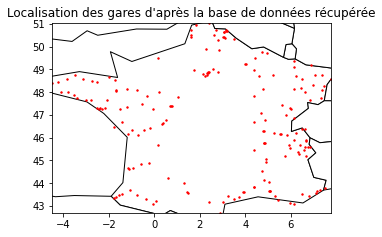

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

points = [Point(lon, lat) for ind, lat, lon in coordonnees[['Latitude', 'Longitude']].itertuples()]
enedis = gpd.GeoDataFrame(data=dict(geometry=points))
enedis['Nom'] = coordonnees['Nom_Gare']
enedis.head()

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

from shapely.geometry import Polygon
europe = world[world.continent == "Europe"].copy()
europe['geometry'] = europe.geometry.intersection(Polygon([(-10,35), (50,35), (50,70), (-10, 70)]))
europe.head()

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
minx, miny, maxx, maxy = enedis.total_bounds

europe.plot(ax=ax, color='white', edgecolor='black')
enedis.plot(ax=ax, marker='o', color='red', markersize=2)
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_title("Localisation des gares d'après la base de données récupérée");

On utilise le module Geod de pyproj pour déterminer les distances en kms. 

In [ ]:
from pyproj import Geod

In [ ]:
wgs84_geod = Geod(ellps ='WGS84')


def Distance(lat1,lon1,lat2,lon2):
     az12,az21,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2) 
     return dist

In [ ]:
nom_gare = coordonnees['Nom_Gare'].tolist()
latitude = coordonnees['Latitude'].tolist()
longitude = coordonnees['Longitude'].tolist()

liste = [[] for i in range(len(nom_gare))]

for i in range(len(liste)) : 
    liste[i] = nom_gare[i], latitude[i], longitude[i]
    
#liste

liste contient les triplets (nom de gare, latitude, longitude) pour chaque gare. Pour chaque couple de gares contenues dans cette liste, on calcule la distance entre ces deux gares que l'on stocke dans le dictionnaire distance. 

In [ ]:
distance = {}
for k in range(len(liste)) : 
    for j in range(len(liste)) : 
        distance[liste[j][0], liste[k][0]] = Distance(liste[j][1],liste[j][2], liste[k][1], liste[k][2])
        
        
gares = list(distance.keys())
gare_depart = [gares[k][0] for k in range(len(gares))]
gare_arrivee = [gares[k][1] for k in range(len(gares))]

On crée le DataFrame distance_villes qui pour une gare de départ et une gare d'arrivée donne la distance en kms entre ces deux gares. 

In [ ]:
distance_villes = pd.DataFrame({'Gare de départ' : gare_depart, 'Gare d arrivée' : gare_arrivee, 'Distance entre les villes' : list(distance.values())})
distance_villes['Distance entre les villes'] = distance_villes['Distance entre les villes']/1000

  On veut désormais combiner les deux DataFrame : bdd_sncf et distance_villes, afin d'obtenir un DataFrame final contenant : 
- le nom de la gare de départ, 
- le nom de la gare d'arrivée, 
- les tarifs correspondants,
- la distance correspondante à ce trajet. 

    Cependant, ces deux bases de données étant issues de jeux de données différents, **la syntaxe des noms de gares est différente**. Par exemple, les noms de gares dans bdd_sncf sont affichés en majuscule et sans caractères spéciaux (en particulier les tirets). On doit donc modifier la syntaxe des noms de gares contenues dans distance_villes. 

In [ ]:
distance_villes['Gare de départ'] = distance_villes['Gare de départ'].str.upper()
distance_villes['Gare d arrivée'] = distance_villes['Gare d arrivée'].str.upper()
distance_villes = distance_villes.replace('\-', ' ', regex = True)
distance_villes.iloc[2502]

Gare de départ                  SÉLESTAT
Gare d arrivée               CARCASSONNE
Distance entre les villes        687.594
Name: 2502, dtype: object

Il reste néanmoins des différences entre les noms qui pointent vers des gares identiques. Pour résoudre ce problème on utilise le module Levenshtein qui permet de définir un **ratio de ressemblance entre deux chaînes de caractères**. 
On crée la fonction *ratio* qui pour une gare de départ $x$ et une gare d'arrivée $y$ de bdd_sncf, retourne l'indice de la ligne de distance_villes du trajet de $x$ à $y$ correspondant. 

In [ ]:
import Levenshtein as lev

garedepartmaj = distance_villes['Gare de départ'].tolist() 
garearrmaj = distance_villes['Gare d arrivée'].tolist()

def ratio(x,y):
    garedep = []
    ratiosd = []
    ratiosa =[]
    for gare in garedepartmaj :
        Ratio_dep = lev.ratio(gare, x) # on calcule pour chaque gare de départ de distance_villes le ratio de similitude avec x
        ratiosd.append(Ratio_dep) # la liste ratiosd stocke l'ensemble des ratios
    ratiomaxd = max(ratiosd) #on prend le max de ces ratios
    
    for i in range (len(ratiosd)):
        if ratiosd[i] == ratiomaxd:
            garedep.append(i) # on stocke dans garedep les indices des gares de départ pour lesquelles le ratio est maximal
    
    for index in garedep : 
        Ratio_arr = lev.ratio(garearrmaj[index], y) #on regarde les ratios de similitude avec la gare d'arrivée pour les gares dans garedep 
        ratiosa.append(Ratio_arr)
    
    ratiomaxa=max(ratiosa)
    for i in range (len(ratiosa)):
        if ratiosa[i] == ratiomaxa:
            return(garedep[i]) #on retourne l'indice de la ligne de distances_villes pour laquelle la gare de départ et la gare 
        #d'arrivée ont le plus grand ratio de similitude avec les gares x et y. 


NameError: name 'distance_villes' is not defined

In [ ]:
distancegares=[]
for i in range(len(liste_gare_départ)):
    départ =liste_gare_départ[i]
    arrivée = liste_gare_arrivée[i]
    distancegares.append(distance_villes['Distance entre les villes'][ratio(départ,arrivée)])

#print(distancegares) 
# distancegares contient l'ensemble des distances pour les trajets de bdd_sncf. 


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065


3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707


On ajoute finalement la colonne distance à la DataFrame bdd_sncf. 

In [ ]:
bdd_sncf['Distance du trajet'] = distancegares
bdd_sncf
#len(distancegareskm)

,Gare de départ,Gare d arrivée,Prix d appel seconde,Plein tarif loisir seconde,Tarif premiere classe,Distance du trajet
0,NIMES,LILLE EUROPE,30.0,144.0,184.0,763.449423
1,MOUTIERS SALINS BRIDES,QUIMPER,30.0,147.0,190.0,862.330700
2,LANDRY,QUIMPER,30.0,147.0,190.0,869.234024
3,TGV HAUTE PICARDIE,AGDE,30.0,150.0,188.0,728.928052
4,TGV HAUTE PICARDIE,SETE,30.0,150.0,188.0,720.162028
...,...,...,...,...,...,...
4157,PLOUARET TREGOR,PARIS MONTPARNASSE 1 ET 2,20.0,99.0,138.0,310.594709
4158,DOL DE BRETAGNE,PARIS MONTPARNASSE 1 ET 2,20.0,95.0,138.0,300.186787
4159,MARNE LA VALLEE CHESSY,MORLAIX,20.0,99.0,138.0,487.541717
4160,QUIMPERLE,MARNE LA VALLEE CHESSY,20.0,103.0,147.0,481.344754


In [ ]:
bdd_sncf.to_csv('bdd_sncf.csv', header = True, index = False)

# **2. Visualisation**

In [ ]:
import pandas as pd
from scipy import stats
import seaborn as sn
import scipy
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [ ]:
bdd_1 = pd.read_csv('bdd_avion_1.csv', encoding = 'latin-1')
bdd_2 = pd.read_csv('bdd_avion_2.csv', encoding = 'latin-1')
bdd_3 = pd.read_csv('bdd_avion_3.csv', encoding = 'latin-1')
bdd_sncf = pd.read_csv('bdd_sncf.csv', encoding = 'latin-1')

- *bdd_1* donne pour chaque vol, son prix moyen aller-retour;
- *bdd_2* donne pour chaque vol, son prix et le mois du vol;
- *bdd_3* donne pour chaque vol, son prix et le délais entre la réservation et le vol;
- *bdd_sncf* donne pour chaque trajet de train, le prix en première et seconde classes ainsi que la distance du trajet en kms.

Nous voulons regarder s'il existe une **corrélation entre le prix des billets d'avion et les variables suivantes** : 
- le prix des billets de train,
- la distance du trajet. 
- le mois du vol,
- le délais entre la réservation et le vol.

## 1. Corrélation avec le prix des billets de train

On cherche d'une part à fusionner les bases de données *bdd_sncf* et *bdd_1* afin d'obtenir pour chaque trajet, le prix moyen du billet d'avion et le prix moyen du billet de train. 


Cependant, on remarque que les noms de villes qui qualifient les départs et les arrivées sont différents selon la base de données (par exemple, *bdd_sncf* indique généralement le nom de la gare, et non le nom de la ville). 

In [ ]:
bdd_sncf.head(5)

,Gare de dÃ©part,Gare d arrivÃ©e,Prix d appel seconde,Plein tarif loisir seconde,Tarif premiere classe,Distance du trajet
0,NIMES,LILLE EUROPE,30.0,144.0,184.0,763.449423
1,MOUTIERS SALINS BRIDES,QUIMPER,30.0,147.0,190.0,862.330700
2,LANDRY,QUIMPER,30.0,147.0,190.0,869.234024
3,TGV HAUTE PICARDIE,AGDE,30.0,150.0,188.0,728.928052
4,TGV HAUTE PICARDIE,SETE,30.0,150.0,188.0,720.162028


In [ ]:
bdd_1.head(5)

,Column1,Départ,Arrivée,Prix
0,0,Paris,Strasbourg,251
1,1,Nantes,Strasbourg,180
2,2,Marseille,Strasbourg,220
3,3,Bordeaux,Strasbourg,229
4,4,Bruxelles,Strasbourg,204


In [ ]:
bdd_1['Départ'].unique()
bdd_1['Arrivée'].unique()

array(['Strasbourg', 'Bordeaux', 'Clermont-Ferrand', 'Rennes', 'Brest',
       'Ajaccio', 'Bastia', 'Calvi', 'Figari', 'Montpellier', 'Limoges',
       'Metz', 'Toulouse', 'Lille', 'Caen', 'Nantes', 'Poitiers',
       'Marseille', 'Nice', 'Lyon', 'Paris'], dtype=object)

On voit que dans la base de données *bdd_1*, il y a un faible nombre de destinations et de départs. On peut donc changer à la main la syntaxe des départs et des arrivées dans la base de données *bdd_sncf* de façon à ce qu'elle soit identique à celle de *bdd_1*. Pour certaines grandes villes telles que Lyon et Paris comportant plusieurs gares, il ne faudra pas oublier de modifier le nom des toute les gares. 

Puis, on conserve seulement les lignes dont la ville de départ et d'arrivée coïncident avec celles de *bdd_1*. 

In [ ]:
bdd_sncf['Gare de dÃ©part'].loc[(bdd_sncf['Gare de dÃ©part'] == 'PARIS MONTPARNASSE 1 ET 2') | (bdd_sncf['Gare de dÃ©part'] == 'PARIS AUSTERLITZ') | (bdd_sncf['Gare de dÃ©part'] == 'MASSY TGV') | (bdd_sncf['Gare de dÃ©part'] == 'MARNE LA VALLEE CHESSY') | (bdd_sncf['Gare de dÃ©part'] == 'PARIS NORD') | (bdd_sncf['Gare de dÃ©part'] == 'PARIS GARE DE LYON') |(bdd_sncf['Gare de dÃ©part'] == 'AEROPORT CDG 2 TGV ROISSY') | (bdd_sncf['Gare de dÃ©part'] =='MANTES LA J. TGV')] = 'Paris'
bdd_sncf['Gare d arrivÃ©e'].loc[(bdd_sncf['Gare d arrivÃ©e'] == 'PARIS MONTPARNASSE 1 ET 2') | (bdd_sncf['Gare d arrivÃ©e'] == 'PARIS AUSTERLITZ') | (bdd_sncf['Gare d arrivÃ©e'] == 'MASSY TGV') | (bdd_sncf['Gare d arrivÃ©e'] == 'MARNE LA VALLEE CHESSY') | (bdd_sncf['Gare d arrivÃ©e'] == 'PARIS NORD') | (bdd_sncf['Gare d arrivÃ©e'] == 'PARIS GARE DE LYON') |(bdd_sncf['Gare d arrivÃ©e'] == 'AEROPORT CDG 2 TGV ROISSY') | (bdd_sncf['Gare d arrivÃ©e'] =='MANTES LA J. TGV') ] = 'Paris'

bdd_sncf['Gare de dÃ©part'].loc[bdd_sncf['Gare de dÃ©part'] == 'NANTES'] = 'Nantes'
bdd_sncf['Gare d arrivÃ©e'].loc[bdd_sncf['Gare d arrivÃ©e'] == 'NANTES'] = 'Nantes'


bdd_sncf['Gare de dÃ©part'].loc[bdd_sncf['Gare de dÃ©part'] == 'MARSEILLE ST CHARLES'] = 'Marseille'
bdd_sncf['Gare d arrivÃ©e'].loc[bdd_sncf['Gare d arrivÃ©e'] == 'MARSEILLE ST CHARLES'] = 'Marseille'

bdd_sncf['Gare de dÃ©part'].loc[bdd_sncf['Gare de dÃ©part'] == 'BORDEAUX ST JEAN'] = 'Bordeaux'
bdd_sncf['Gare d arrivÃ©e'].loc[bdd_sncf['Gare d arrivÃ©e'] == 'BORDEAUX ST JEAN'] = 'Bordeaux'


bdd_sncf['Gare de dÃ©part'].loc[(bdd_sncf['Gare de dÃ©part'] == 'LYON PART DIEU') | (bdd_sncf['Gare de dÃ©part'] == 'LYON ST EXUPERY') | (bdd_sncf['Gare de dÃ©part'] == 'LYON PERRACHE')] = 'Lyon'
bdd_sncf['Gare d arrivÃ©e'].loc[(bdd_sncf['Gare d arrivÃ©e'] == 'LYON PART DIEU') | (bdd_sncf['Gare d arrivÃ©e'] == 'LYON ST EXUPERY') | (bdd_sncf['Gare d arrivÃ©e'] == 'LYON PERRACHE')] = 'Lyon'

bdd_sncf['Gare de dÃ©part'].loc[bdd_sncf['Gare de dÃ©part'] == 'TOULOUSE MATABIAU'] = 'Toulouse'
bdd_sncf['Gare d arrivÃ©e'].loc[bdd_sncf['Gare d arrivÃ©e'] == 'TOULOUSE MATABIAU'] = 'Toulouse'

bdd_sncf['Gare de dÃ©part'].loc[bdd_sncf['Gare de dÃ©part'] == 'NICE VILLE' ] = 'Nice'
bdd_sncf['Gare d arrivÃ©e'].loc[bdd_sncf['Gare d arrivÃ©e'] == 'NICE VILLE' ] = 'Nice'

bdd_sncf['Gare de dÃ©part'].loc[bdd_sncf['Gare de dÃ©part'] == 'STRASBOURG'] = 'Strasbourg'
bdd_sncf['Gare d arrivÃ©e'].loc[bdd_sncf['Gare d arrivÃ©e'] == 'STRASBOURG'] = 'Strasbourg'

bdd_sncf['Gare de dÃ©part'].loc[bdd_sncf['Gare de dÃ©part'] == 'BREST' ] = 'Brest'
bdd_sncf['Gare d arrivÃ©e'].loc[bdd_sncf['Gare d arrivÃ©e'] == 'BREST' ] = 'Brest'

bdd_sncf['Gare de dÃ©part'].loc[bdd_sncf['Gare de dÃ©part'] == 'MONTPELLIER' ] = 'Montpellier'
bdd_sncf['Gare d arrivÃ©e'].loc[bdd_sncf['Gare d arrivÃ©e'] == 'MONTPELLIER' ] = 'Montpellier'

bdd_sncf['Gare de dÃ©part'].loc[bdd_sncf['Gare de dÃ©part'] == 'LIMOGES BENEDICTINS'] = 'Limoges'
bdd_sncf['Gare d arrivÃ©e'].loc[bdd_sncf['Gare d arrivÃ©e'] == 'LIMOGES BENEDICTINS'] = 'Limoges'

bdd_sncf['Gare de dÃ©part'].loc[bdd_sncf['Gare de dÃ©part'] == 'METZ VILLE'] = 'Metz'
bdd_sncf['Gare d arrivÃ©e'].loc[bdd_sncf['Gare d arrivÃ©e'] == 'METZ VILLE'] = 'Metz'

bdd_sncf['Gare de dÃ©part'].loc[(bdd_sncf['Gare de dÃ©part'] == 'LILLE FLANDRES') | (bdd_sncf['Gare de dÃ©part'] == 'LILLE EUROPE') ] = 'Lille'
bdd_sncf['Gare d arrivÃ©e'].loc[(bdd_sncf['Gare d arrivÃ©e'] == 'LILLE FLANDRES') | (bdd_sncf['Gare d arrivÃ©e'] == 'LILLE EUROPE') ] = 'Lille'

bdd_sncf['Gare de dÃ©part'].loc[bdd_sncf['Gare de dÃ©part'] == 'CAEN' ] = 'Caen'
bdd_sncf['Gare d arrivÃ©e'].loc[bdd_sncf['Gare d arrivÃ©e'] == 'CAEN' ] = 'Caen'

bdd_sncf['Gare de dÃ©part'].loc[bdd_sncf['Gare de dÃ©part'] ==  ' POITIERS'] = 'Poitiers'
bdd_sncf['Gare d arrivÃ©e'].loc[bdd_sncf['Gare d arrivÃ©e'] ==  ' POITIERS'] = 'Poitiers'

bdd_sncf['Gare de dÃ©part'].loc[bdd_sncf['Gare de dÃ©part'] ==  'RENNES'] = 'Rennes'
bdd_sncf['Gare d arrivÃ©e'].loc[bdd_sncf['Gare d arrivÃ©e'] ==  'RENNES'] = 'Rennes'

liste_villes = ['Strasbourg', 'Bordeaux', 'Clermont-Ferrand', 'Rennes', 'Brest',
       'Ajaccio', 'Bastia', 'Calvi', 'Figari', 'Montpellier', 'Limoges',
       'Metz', 'Toulouse', 'Lille', 'Caen', 'Nantes', 'Poitiers',
       'Marseille', 'Nice', 'Lyon', 'Paris','Bordeaux'] ##contient tous les destinations et villes de départ de bdd_1

indexlist=[]
for villedep in liste_villes:
    for villearr in liste_villes:
        inter = bdd_sncf[(bdd_sncf['Gare de dÃ©part'] == villedep)]
        listelement = inter[inter['Gare d arrivÃ©e']==villearr].index.values.astype(int)
        if listelement.size!=0:
            indexlist.append(listelement[0])  ## listelement stocke tous les indices des lignes de bdd_sncf dont les départs 
            #et arrivées sont dans bdd_1. 

bdd_sncf = bdd_sncf[bdd_sncf.index.isin(indexlist)]
bdd_sncf

C:\Users\Mathilde Zobouyan\Anaconda\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Gare de dÃ©part,Gare d arrivÃ©e,Prix d appel seconde,Plein tarif loisir seconde,Tarif premiere classe,Distance du trajet
7,Limoges,Paris,25.0,88.0,111.0,418.951774
85,Paris,Lyon,25.0,97.0,133.0,382.703675
86,Metz,Lyon,20.0,88.0,112.0,384.902365
103,Brest,Paris,20.0,92.0,131.0,505.076392
207,Paris,Montpellier,25.0,114.0,160.0,503.523601
...,...,...,...,...,...,...
3454,Nantes,Paris,20.0,85.0,122.0,336.159718
3754,Marseille,Rennes,30.0,142.0,180.0,773.008188
3871,Strasbourg,Marseille,20.0,124.0,161.0,616.720319
4120,Strasbourg,Lille,25.0,132.0,152.0,410.073399


On effectue la fusion de la nouvelle base obtenue *bdd_sncf* et *bdd_1* de façon à pouvoir comparer les prix des billets de train et ceux d'avion pour un même trajet. 


***bdd_corr_1* contient alors pour chaque trajet aller-retour, le prix du billet de train (dans la colonne "Prix moyen", qui correspond à la moyenne des tarifs de première et de seconde classe) et celui du billet d'avion (dans la colonne "Prix", et qui correspond également à un prix moyen).**

In [ ]:
bdd_corr = pd.merge(bdd_1, bdd_sncf, left_on = [bdd_1['Départ'],bdd_1['Arrivée']], right_on = [bdd_sncf['Gare de dÃ©part'], bdd_sncf['Gare d arrivÃ©e']], how = 'inner')
bdd_corr = bdd_corr.drop(['Gare de dÃ©part', 'Gare d arrivÃ©e', 'Prix d appel seconde', 'Column1', 'key_0', 'key_1'], axis=1)
bdd_corr['Prix moyen'] =bdd_corr['Plein tarif loisir seconde'] + bdd_corr['Tarif premiere classe']
bdd_corr_1 =  bdd_corr.drop(['Distance du trajet', 'Plein tarif loisir seconde', 'Tarif premiere classe', 'Départ', 'Arrivée'], axis = 1)
bdd_corr_1.head(5)

,Prix,Prix moyen
0,148,193.0
1,241,73.0
2,165,322.0
3,158,251.0
4,181,274.0


On peut regarder la répartition des prix pour le train et l'avion à l'aide d'un histogramme afin de voir s'il n'y a pas de valeurs aberrantes. 

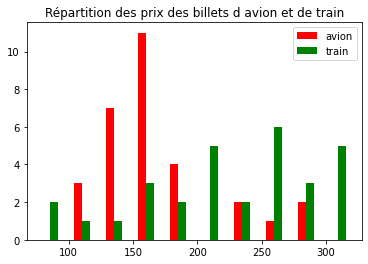

In [ ]:
plt.hist([bdd_corr_1['Prix'], bdd_corr_1['Prix moyen']], rwidth = 0.5, color = ['red', 'green'], label = ['avion', 'train'])
plt.title('Répartition des prix des billets d avion et de train')
plt.legend()

Nous souhaitons regarder s'il existe une corrélation entre ces deux variables, qui sont des variables quantitatives. 

Regardons d'une part s'il existe **une corrélation linéaire entre les deux variables obtenues dans *bdd_corr_1* avec le test de Pearson :** 

In [ ]:
stats.pearsonr(bdd_corr_1['Prix'], bdd_corr_1['Prix moyen'])

(-0.6487444449688861, 0.00010547371513582736)

On voit que le coefficient de Pearson est égal en valeur absolue à $0.65$ avec une p-value de $0.0001$. Ainsi, si on fixe un seuil de significativité à $1$%, on peut donc affirmer que le coefficient de corrélation est significatif. Le coefficient de Pearson en valeur absolue est relativement proche de 1, donc on peut dire qu'il existe une relation linéaire modérée entre le prix des billets de train et celui des billets d'avion. 

On réalise une régression avec le module seaborn : 

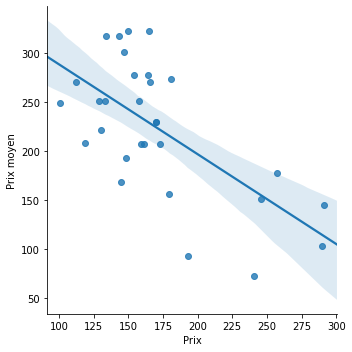

In [ ]:
## Représentation graphique
sn.lmplot(x = 'Prix', y = 'Prix moyen', data = bdd_corr_1)

On remarque que de nombreux points sont espacés de la droite de régression linéaire simple; cette régression est donc de qualité médiocre.

Pour plus de précision sur la régression, on utilise le module statsmodels :

In [ ]:
X = sm.add_constant(bdd_corr_1['Prix'])
model = sm.OLS(bdd_corr_1['Prix moyen'], X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             Prix moyen   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     20.35
Date:                Thu, 05 Nov 2020   Prob (F-statistic):           0.000105
Time:                        15:39:31   Log-Likelihood:                -160.66
No. Observations:                  30   AIC:                             325.3
Df Residuals:                      28   BIC:                             328.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        380.0548     35.896     10.588      0.0

C:\Users\Mathilde Zobouyan\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


D'après les résultats obtenus, on constate que $R²$ = $0.421$ donc la modélisation par la droite des moindres carrés explique 42 % de la variation totale, ce qui constitue un résultat moyen.  

On peut regarder désormais s'il existe un lien non linéaire entre les deux variables étudiées, en regardant par exemple le coefficient de Spearman. 

In [ ]:
stats.spearmanr(bdd_corr_1['Prix'], bdd_corr_1['Prix moyen'])

SpearmanrResult(correlation=-0.5246745612138584, pvalue=0.0029147575377268774)

Le coefficient de corrélation de Spearman est significatif au seuil de $5$% (p-value faible, égale à $0.0029$), il est égal en valeur absolue à $0.52$ donc la dépendance entre les deux variables est modérée. Par ailleurs, ce coefficient est négatif ce qui indique que **plus les billets de train sont chers, plus les prix des billets d'avion sont faibles.**

## 2. Corrélation avec la distance

**La base de données *bdd_corr_2* contient pour chaque trajet, le prix et la distance du trajet associée.**

In [ ]:
bdd_corr_2 = bdd_corr.drop(['Prix moyen'], axis = 1)
bdd_corr_2.head(5)

,Départ,Arrivée,Prix,Plein tarif loisir seconde,Tarif premiere classe,Distance du trajet
0,Paris,Rennes,148,80.0,113.0,329.462708
1,Nantes,Rennes,241,30.0,43.0,95.330640
2,Marseille,Rennes,165,142.0,180.0,773.008188
3,Lyon,Rennes,158,108.0,143.0,560.838254
4,Paris,Montpellier,181,114.0,160.0,503.523601


Puisqu'il s'agit de deux variables quantitatives, on peut regarder leur corrélation de la même façon que fait précédemment avec le prix des billets de train. 

In [ ]:
## Test de Pearson
stats.pearsonr(bdd_corr_2['Prix'], bdd_corr_2['Distance du trajet'])

(-0.5633558260528888, 0.001189008540255743)

Le coefficient de Pearson étant significatif (p-value faible) et égal en valeur absolue à $0.56$, on peut affirmer qu'il existe une relation linéaire entre les 2 variables modérée. 

#### Représentation graphique avec seaborn

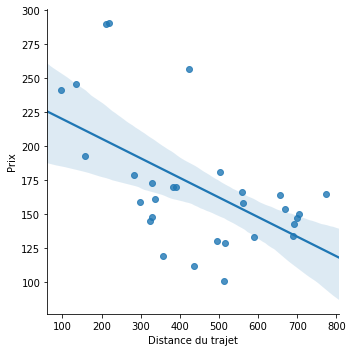

In [ ]:
sn.lmplot(x = 'Distance du trajet', y = 'Prix', data = bdd_corr_2)

Contrairement avec le prix des billets de train où cette variable semble fortement corrélée avec la distance : 

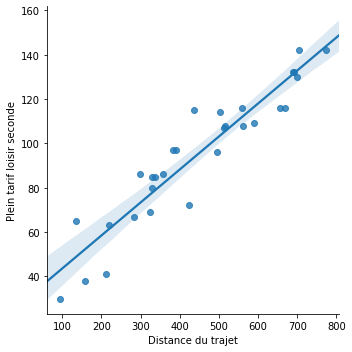

In [ ]:
sn.lmplot(x = 'Distance du trajet', y = 'Plein tarif loisir seconde', data = bdd_corr_2)

#### Utilisation du module statsmodels

In [ ]:
X = sm.add_constant(bdd_corr_2['Distance du trajet'])
model = sm.OLS(bdd_corr_1['Prix'], X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Prix   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     13.02
Date:                Thu, 05 Nov 2020   Prob (F-statistic):            0.00119
Time:                        15:39:33   Log-Likelihood:                -152.79
No. Observations:                  30   AIC:                             309.6
Df Residuals:                      28   BIC:                             312.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                234.4058     19

C:\Users\Mathilde Zobouyan\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


D'après les résultats obtenus, $R²$ est faible : la modélisation par la méthode des moindres carrés explique 31.7% de la variation totale, ce qui constitue une précision faible. 

On regarde le coefficient de Spearman pour déterminer une possible corrélation non linéaire :

In [ ]:
stats.spearmanr(bdd_corr_2['Prix'], bdd_corr_2['Distance du trajet'])

SpearmanrResult(correlation=-0.527756149666889, pvalue=0.002724200097223629)

Le coefficient de Spearman est significatif (p-valeur faible) et est égal en valeur absolue à $0.53$ donc il est difficile d'interpréter une corrélation non linéaire entre les deux variables. 

## 3. Corrélation avec le mois du vol 

Regardons dans un premier temps la répartition des prix des billets d'avion. 

Text(0.5, 1.0, 'Répartition des prix des billets d avion')

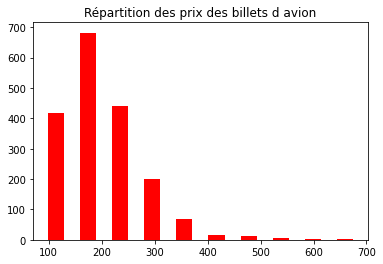

In [ ]:
plt.hist(bdd_2['Prix'], rwidth = 0.5, color = 'red')
plt.title('Répartition des prix des billets d avion')

Nous pouvons constater qu'il existe **plusieurs valeurs aberrantes de prix pour les billets d'avion** : par exemple des billets de plus de $1000 €$. Déterminons les trajets pour lesquels les valeurs de prix sont aberrantes  :

In [ ]:
bdd_2[bdd_2['Prix']>500]

,Column1,Départ,Arrivée,Prix,Mois
27,27,Marseille,Strasbourg,602,avr
82,82,Toulouse,Strasbourg,516,jan
513,513,Bruxelles,Ajaccio,638,déc
613,613,Bruxelles,Bastia,572,avr
621,621,Bruxelles,Bastia,689,déc
720,720,Bruxelles,Calvi,529,avr
1000,1000,Marseille,Limoges,509,août
1512,1512,Paris,Poitiers,556,nov
1521,1521,Marseille,Poitiers,590,août
1524,1524,Marseille,Poitiers,532,nov


 On constate que certains tarifs sont extrêmement élevés car pour des trop courtes distances, il n'existe pas de vol direct et donc une voire plusieurs correspondances sont proposées en remplacement. On supprime donc ces quelques valeurs aberrantes de la base de données.

In [ ]:
bdd_2.drop(bdd_2.loc[(bdd_2['Départ'] == 'Nice') & (bdd_2['Arrivée'] == 'Marseille')].index, inplace = True)
bdd_2.drop(bdd_2.loc[(bdd_2['Départ'] == 'Bordeaux') & (bdd_2['Arrivée'] == 'Nantes')].index, inplace = True)
bdd_2.drop(bdd_2.loc[(bdd_2['Départ'] == 'Toulouse') & (bdd_2['Arrivée'] == 'Montpellier')].index, inplace = True)
bdd_2.drop(bdd_2.loc[(bdd_2['Départ'] == 'Marseille') & (bdd_2['Arrivée'] == 'Montpellier')].index, inplace = True)
bdd_2.drop(bdd_2.loc[(bdd_2['Départ'] == 'Bordeaux') & (bdd_2['Arrivée'] == 'Montpellier')].index, inplace = True)
bdd_2.drop(bdd_2.loc[(bdd_2['Départ'] == 'Nice') & (bdd_2['Arrivée'] == 'Ajaccio')].index, inplace = True)
bdd_2.drop(bdd_2.loc[(bdd_2['Départ'] == 'Paris') & (bdd_2['Arrivée'] == 'Strasbourg')].index, inplace = True)
bdd_2.drop(bdd_2.loc[(bdd_2['Départ'] == 'Toulouse') & (bdd_2['Arrivée'] == 'Bordeaux')].index, inplace = True)
bdd_2

,Column1,Départ,Arrivée,Prix,Mois
12,12,Nantes,Strasbourg,273,jan
13,13,Nantes,Strasbourg,179,fév
14,14,Nantes,Strasbourg,170,mar
15,15,Nantes,Strasbourg,174,avr
16,16,Nantes,Strasbourg,168,mai
...,...,...,...,...,...
1943,1943,Nice,Paris,150,août
1944,1944,Nice,Paris,124,sep
1945,1945,Nice,Paris,124,oct
1946,1946,Nice,Paris,119,nov


**bdd_corr_3 contient pour chaque vol, le prix du billet aller retour selon le mois correspondant.**

In [ ]:
bdd_corr_3 = bdd_2.drop(['Column1'], axis = 1)
bdd_corr_3 = bdd_corr_3.pivot_table(index = ['Départ', 'Arrivée'], columns = 'Mois', values = 'Prix')
bdd_corr_3 = bdd_corr_3.reset_index()
bdd_corr_3 = bdd_corr_3.drop(['Départ', 'Arrivée'], axis = 1)
bdd_corr_3

Mois,août,avr,déc,fév,jan,juil,juin,mai,mar,nov,oct,sep
0,249.0,266.0,241.0,209.0,209.0,266.0,259.0,257.0,319.0,214.0,169.0,164.0
1,338.0,363.0,243.0,200.0,192.0,322.0,349.0,310.0,315.0,221.0,206.0,189.0
2,158.0,217.0,165.0,172.0,137.0,165.0,187.0,191.0,179.0,134.0,148.0,157.0
3,253.0,218.0,233.0,241.0,NaN,220.0,225.0,200.0,213.0,206.0,199.0,169.0
4,292.0,266.0,231.0,170.0,165.0,271.0,262.0,238.0,189.0,160.0,215.0,214.0
...,...,...,...,...,...,...,...,...,...,...,...,...
154,156.0,132.0,129.0,126.0,102.0,153.0,147.0,124.0,182.0,108.0,115.0,140.0
155,140.0,112.0,115.0,109.0,109.0,148.0,149.0,124.0,111.0,108.0,120.0,116.0
156,500.0,278.0,NaN,NaN,NaN,301.0,245.0,257.0,336.0,NaN,NaN,NaN
157,185.0,138.0,198.0,179.0,129.0,162.0,137.0,144.0,298.0,137.0,145.0,124.0


On voit qu'il y a plusieurs valeurs manquantes. Nous pouvons dans un premier temps les remplacer par la médiane du prix du billet du trajet correspondant. 

In [ ]:
bdd_corr_3_new = bdd_corr_3.T
for i in range(1,159) : 
    median = bdd_corr_3_new[i].median()
    bdd_corr_3_new[i].fillna(median, inplace=True)  
bdd_corr_3 = bdd_corr_3_new.T
bdd_corr_3.head(5)

Mois,août,avr,déc,fév,jan,juil,juin,mai,mar,nov,oct,sep
0,249.0,266.0,241.0,209.0,209.0,266.0,259.0,257.0,319.0,214.0,169.0,164.0
1,338.0,363.0,243.0,200.0,192.0,322.0,349.0,310.0,315.0,221.0,206.0,189.0
2,158.0,217.0,165.0,172.0,137.0,165.0,187.0,191.0,179.0,134.0,148.0,157.0
3,253.0,218.0,233.0,241.0,218.0,220.0,225.0,200.0,213.0,206.0,199.0,169.0
4,292.0,266.0,231.0,170.0,165.0,271.0,262.0,238.0,189.0,160.0,215.0,214.0


On regarde tout d'abord l'allure de l'évolution des prix selon les mois pour plusieurs trajets aléatoires. 

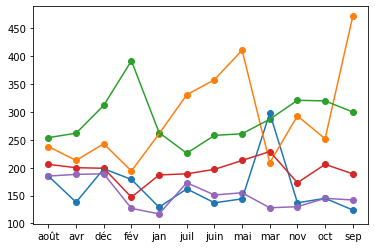

In [ ]:
bdd_corr_3_test = bdd_corr_3.sample(10)
bdd_corr_3_test = bdd_corr_3_test.reset_index()
bdd_corr_3_test = bdd_corr_3_test.drop(['index'], axis = 1)
x = bdd_corr_3_test.columns
for i in range(5) :
    plt.scatter(x,bdd_corr_3_test.loc[i])
    plt.plot(x,bdd_corr_3_test.loc[i], linestyle= 'solid')


En observant les courbes pour plusieurs échantillons de trajets, il semble difficile de déterminer une évolution similaire entre elles.

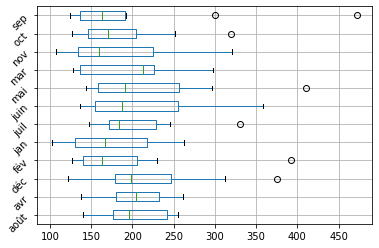

In [ ]:
boxplot = bdd_corr_3_test.boxplot(column = bdd_corr_3_test.columns.tolist(), fontsize = 10, rot = 45, vert = 0)
boxplot

D'après les boîtes de Tukey précédentes on constate que : 
- les écarts interquartiles sont sensiblement identiques pour les mois de janvier, mars, main, juin, novembre d'une part, et avril, juillet, août, septembre, octobre d'autre part, avec un écart interquartile nettement plus faible. Cela signifie que les prix sont bien plus hétérogènes pour le premier groupe que pour le second groupe. 
- l'étendue des boîtes pour les mois de mai et juin sont extrêmement importantes; les prix sont donc particulièrement hétérogènes pour ces deux mois; 
- il existe quelques valeurs aberrantes qui peuvent fausser les résultats obtenus. 

## 4. Corrélation avec le délais de réservation

In [ ]:
bdd_3.drop(bdd_3.loc[(bdd_3['Départ'] == 'Nice') & (bdd_3['Arrivée'] == 'Marseille')].index, inplace = True)
bdd_3.drop(bdd_3.loc[(bdd_3['Départ'] == 'Bordeaux') & (bdd_3['Arrivée'] == 'Nantes')].index, inplace = True)
bdd_3.drop(bdd_3.loc[(bdd_3['Départ'] == 'Toulouse') & (bdd_3['Arrivée'] == 'Montpellier')].index, inplace = True)
bdd_3.drop(bdd_3.loc[(bdd_3['Départ'] == 'Marseille') & (bdd_3['Arrivée'] == 'Montpellier')].index, inplace = True)
bdd_3.drop(bdd_3.loc[(bdd_3['Départ'] == 'Bordeaux') & (bdd_3['Arrivée'] == 'Montpellier')].index, inplace = True)
bdd_3.drop(bdd_3.loc[(bdd_3['Départ'] == 'Nice') & (bdd_3['Arrivée'] == 'Ajaccio')].index, inplace = True)
bdd_3.drop(bdd_3.loc[(bdd_3['Départ'] == 'Paris') & (bdd_3['Arrivée'] == 'Strasbourg')].index, inplace = True)
bdd_3.drop(bdd_3.loc[(bdd_3['Départ'] == 'Toulouse') & (bdd_3['Arrivée'] == 'Bordeaux')].index, inplace = True)
bdd_3

,Column1,Départ,Arrivée,Prix,Temps entre la réservation et le vol
12,12,Nantes,Strasbourg,234,0 à 1 mois
13,13,Nantes,Strasbourg,190,1 à 2 mois
14,14,Nantes,Strasbourg,139,2 à 3 mois
15,15,Nantes,Strasbourg,165,3 à 4 mois
16,16,Nantes,Strasbourg,163,4 à 5 mois
...,...,...,...,...,...
1618,1618,Nice,Paris,119,7 à 8 mois
1619,1619,Nice,Paris,124,8 à 9 mois
1620,1620,Nice,Paris,149,9 à 10 mois
1621,1621,Nice,Paris,127,10 à 11 mois


**bdd_corr_4 contient pour chaque vol, le prix aller retour pour chaque délais de réservation**. 

In [ ]:
bdd_corr_4 = bdd_3.drop(['Column1'], axis =1)
bdd_corr_4 = bdd_corr_4.pivot_table(index = ['Départ', 'Arrivée'], columns = 'Temps entre la réservation et le vol', values = 'Prix')
bdd_corr_4 = bdd_corr_4.reset_index()
bdd_corr_4 = bdd_corr_4.drop(['Départ', 'Arrivée'], axis = 1)
bdd_corr_4
bdd_corr_4

Temps entre la réservation et le vol,0 à 1 mois,1 à 2 mois,10 à 11 mois,11 à 12 mois,2 à 3 mois,3 à 4 mois,4 à 5 mois,5 à 6 mois,6 à 7 mois,7 à 8 mois,8 à 9 mois,9 à 10 mois
0,170.0,146.0,196.0,194.0,144.0,226.0,373.0,281.0,350.0,308.0,404.0,241.0
1,216.0,187.0,268.0,270.0,184.0,290.0,332.0,422.0,396.0,559.0,363.0,286.0
2,184.0,175.0,113.0,117.0,167.0,153.0,160.0,158.0,147.0,152.0,121.0,111.0
3,245.0,196.0,NaN,NaN,184.0,189.0,191.0,NaN,NaN,NaN,NaN,NaN
4,268.0,226.0,NaN,NaN,209.0,226.0,234.0,233.0,244.0,304.0,329.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
154,151.0,137.0,285.0,200.0,118.0,153.0,118.0,123.0,124.0,135.0,128.0,140.0
155,123.0,110.0,127.0,143.0,108.0,130.0,132.0,126.0,177.0,117.0,160.0,196.0
156,338.0,354.0,NaN,NaN,299.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157,182.0,141.0,NaN,NaN,143.0,174.0,158.0,160.0,138.0,148.0,NaN,NaN


On voit qu'il y a plusieurs valeurs manquantes. Nous pouvons dans un premier temps les remplacer par la médiane du prix du billet du trajet correspondant. 

In [ ]:
bdd_corr_4_new = bdd_corr_4.T
for i in range(1,159) : 
    median = bdd_corr_4_new[i].median()
    bdd_corr_4_new[i].fillna(median, inplace=True)  
bdd_corr_4 = bdd_corr_4_new.T
bdd_corr_4.head(5)

Temps entre la réservation et le vol,0 à 1 mois,1 à 2 mois,10 à 11 mois,11 à 12 mois,2 à 3 mois,3 à 4 mois,4 à 5 mois,5 à 6 mois,6 à 7 mois,7 à 8 mois,8 à 9 mois,9 à 10 mois
0,170.0,146.0,196.0,194.0,144.0,226.0,373.0,281.0,350.0,308.0,404.0,241.0
1,216.0,187.0,268.0,270.0,184.0,290.0,332.0,422.0,396.0,559.0,363.0,286.0
2,184.0,175.0,113.0,117.0,167.0,153.0,160.0,158.0,147.0,152.0,121.0,111.0
3,245.0,196.0,191.0,191.0,184.0,189.0,191.0,191.0,191.0,191.0,191.0,191.0
4,268.0,226.0,234.0,234.0,209.0,226.0,234.0,233.0,244.0,304.0,329.0,234.0


Déterminons tout d'abord l'allure de l'évolution des prix selon le délais de réservation. 

In [ ]:
bdd_corr_4_test = bdd_corr_4.sample(10)
bdd_corr_4_test = bdd_corr_4_test.reset_index()
bdd_corr_4_test = bdd_corr_4_test.drop(['index'], axis = 1)

x = bdd_corr_4_test.columns ## on réordonne x, ie on place les éléments 10 à 11 mois et 11 à 12 mois en fin de liste
x = x.tolist()
a = x[2]
b = x[3]
del x[2:4]
x.append(a)
x.append(b)


Text(0.5, 1.0, 'Evolution du prix du billet selon le délais de réservation pour dix trajets')

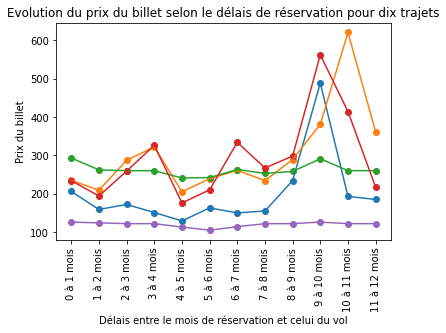

In [ ]:
for i in range(5) :
    plt.scatter(x,bdd_corr_4_test.loc[i])
    plt.plot(x,bdd_corr_4_test.loc[i], linestyle= 'solid')
    
plt.xticks(rotation = 90)
plt.xlabel('Délais entre le mois de réservation et celui du vol')
plt.ylabel('Prix du billet')
plt.title('Evolution du prix du billet selon le délais de réservation pour dix trajets')


Etant donné que les courbes suivent une trajectoire plus ou moins similaire, il semblerait qu'il existe une corrélation entre les deux variables étudiées. 

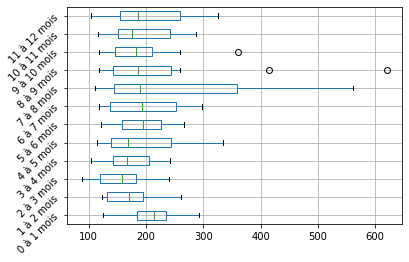

In [ ]:
boxplot = bdd_corr_4_test.boxplot(column = x, fontsize = 10, rot = 45, vert = 0)
boxplot

Si on remplace désormais les valeurs manquantes par la moyenne des prix du billet du trajet correspondant, et que l'on opère de même : 

In [ ]:
bdd_corr_4_new = bdd_corr_4.T
for i in range(1,159) : 
    mean = bdd_corr_4_new[i].mean()
    bdd_corr_4_new[i].fillna(mean, inplace=True)  
bdd_corr_4 = bdd_corr_4_new.T
bdd_corr_4.head(5)

bdd_corr_4_test_1 = bdd_corr_4.sample(10)
bdd_corr_4_test_1 = bdd_corr_4_test_1.reset_index()
bdd_corr_4_test_1 = bdd_corr_4_test_1.drop(['index'], axis = 1)

x = bdd_corr_4_test_1.columns ## on réordonne x, ie on place les éléments 10 à 11 mois et 11 à 12 mois en fin de liste
x = x.tolist()
a = x[2]
b = x[3]
del x[2:4]
x.append(a)
x.append(b)

Text(0.5, 1.0, 'Evolution du prix du billet selon le délais de réservation pour dix trajets')

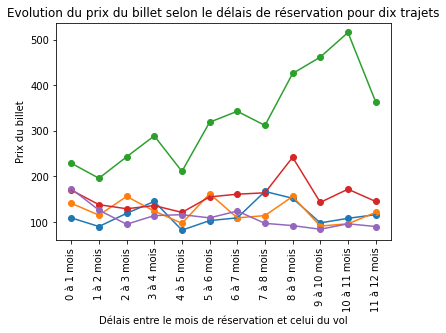

In [ ]:
for i in range(5) :
    plt.scatter(x,bdd_corr_4_test_1.loc[i])
    plt.plot(x,bdd_corr_4_test_1.loc[i], linestyle= 'solid')
    
plt.xticks(rotation = 90)
plt.xlabel('Délais entre le mois de réservation et celui du vol')
plt.ylabel('Prix du billet')
plt.title('Evolution du prix du billet selon le délais de réservation pour dix trajets')


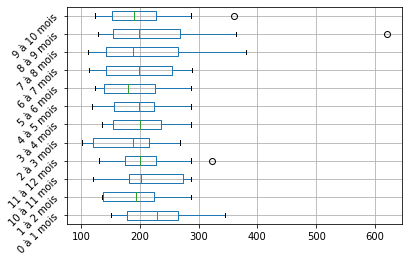

In [ ]:
boxplot = bdd_corr_4_test_1.boxplot(column = bdd_corr_4_test_1.columns.tolist(), fontsize = 10, rot = 45, vert = 0)
boxplot

## Conclusion 

D'après les résultats précédents, on peut conclure que :
- il existe une relation linéaire modérée entre les prix des billets d'avion et ceux de train. En particulier, **les deux variables sont négativement corrélées**,
- il n'existe pas vraiment de relation entre les prix des billets d'avion et la distance du trajet,
- relation avec les délais de réservation et les mois à définir? 


# **3. Modélisation**

### **Preprocessing**

##### **Standardisation et normalisation des données**

##### **Encodage des valeurs catégorielles**

### **Modéles**

##### **Modèle de SVM**

##### **Modèle de régression**

##### **Modèle de clustering**

### **Evaluation des modèles**